In [1]:
import tweepy
import pandas as pd

import os

In [2]:
token = os.getenv('A_BEARER_TOKEN')

client = tweepy.Client(token)

In [4]:
start_date = '2021-01-01T00:00:00Z'
end_date = '2022-01-01T00:00:00Z'

In [5]:
granularity = 'day'

In [21]:
query = '"food systems" -is:reply -is:retweet -is:quote'

In [22]:
responses = []
for response in tweepy.Paginator(client.get_all_tweets_count, query,
                                    start_time=start_date,
                                 end_time=end_date,
                                 granularity=granularity):
    responses.append(response)

In [24]:
count_list = []
for resp in responses:
    count_list.extend(resp.data)

df = pd.DataFrame(count_list)

df['start'] = pd.to_datetime(df['start'])
df = df.set_index('start')

In [26]:
df['tweet_count'].sum()

73003

## Getting the tweets

WE have 73k tweets to gather.

In [27]:
max_results = 500
tweet_fields = 'public_metrics,geo,created_at,author_id'
user_fields = 'public_metrics,location,description,created_at'

In [56]:
responses = []
for response in tweepy.Paginator(client.search_all_tweets, query,
                                    start_time=start_date,
                                     end_time=end_date,
                                     max_results=max_results,
                                 tweet_fields=tweet_fields,
                                 user_fields=user_fields,
                                expansions='author_id'):
    responses.append(response)

In [57]:
type(responses[11])

tweepy.client.Response

In [67]:
responses[0].includes['users'][0].description

'IT Project Leader and \nBike Whisperer'

In [113]:
tweets = []
users = []
for response in responses:
    data = response.data
    user = response.includes['users']
    for datum in data:
        pm = datum.public_metrics
        ai = datum.author_id
        geo = datum.geo
        ca = datum.created_at
        t = datum.text
        tid = datum.id
        tweets.append([tid, t, ca, ai, pm, geo])
    for u in user:
        pm = u.public_metrics
        de = u.description
        ai = u.id
        ca = u.created_at
        lo = u.location
        na = u.name
        un = u.username
        users.append([ai, na, un, de, ca, pm, lo])
tweets = pd.DataFrame(tweets, columns=['id', 'text', 'created_at', 'author_id', 'public_metrics', 'geo'])
users = pd.DataFrame(users, columns=['author_id', 'name', 'username', 'description', 'created_at', 'public_metrics', 'location'])

In [76]:
def get_likes(x):
    return x['like_count']

In [114]:
tweets['likes'] = tweets['public_metrics'].apply(get_likes)
tweets['RT'] = tweets['public_metrics'].apply(lambda x: x['retweet_count'])
tweets['replies'] = tweets['public_metrics'].apply(lambda x: x['reply_count'])
tweets['quotes'] = tweets['public_metrics'].apply(lambda x: x['quote_count'])

In [115]:
tweets = tweets.sort_values('likes', ascending=False)

In [111]:
tweets = tweets.merge(users[['author_id', 'name', 'description']], how='left')

In [120]:
users['author_id'].nunique()

27367

In [127]:
users[users['author_id']==1222482817680072704]['name'].unique()

array(['UN Food Systems Coordination Hub'], dtype=object)

In [129]:
users.groupby('author_id')['description'].nunique().sort_values()

author_id
10367                  1
851779879804825600     1
851778482996695040     1
851745265296060416     1
851687412556333057     1
                      ..
482455281              1
482353209              1
482128456              1
482046883              1
1476280663192051735    1
Name: description, Length: 27367, dtype: int64

In [136]:
tweets = tweets.merge(users[['author_id', 'name', 'username', 'description']], how='left').drop_duplicates(subset=['id'])

In [145]:
tweets.to_csv('../data/food_systems_21_22_tweets.csv', index=False)
users.to_csv('../data/food_systems_21_22_users.csv', index=False)

In [143]:
tweets.groupby(['name'])['likes'].mean().sort_values(ascending=False).head(40)

name
Vice President Kamala Harris       12857.000000
NASA                                7110.000000
Lev                                 6725.000000
Government of Brazil                4826.000000
Ocean Panel                         3841.250000
Bezos Earth Fund                    3216.000000
Farmchain.Finance                   3164.000000
Dharmendra Malik                    2232.000000
Alastair Trickett                   1926.000000
HH Sheikh Mohammed                  1697.000000
Kiren Rijiju                        1496.000000
NASA's Kennedy Space Center         1397.000000
Megan McArthur                      1397.000000
The Daily Show                      1368.000000
The Rockefeller Foundation          1258.281250
Matt 🌊                              1039.000000
Shobha Karandlaje                   1026.000000
BBC News (UK)                        976.000000
Smriti Z Irani                       938.000000
Robert F. Kennedy Jr                 929.500000
Kisan Ekta Morcha                  

In [139]:
tweets['name'].head(40)

0           The Rockefeller Foundation
27                         Ocean Panel
31        Vice President Kamala Harris
32            UN Environment Programme
69          The Rockefeller Foundation
96                                NASA
97                                 Lev
98                Government of Brazil
99                        João Campari
155                   Economist Impact
174                              Devex
229                   Bezos Earth Fund
230         The Rockefeller Foundation
257                  Farmchain.Finance
258                   Economist Impact
277                     The Daily Show
279         The Rockefeller Foundation
306                   Dharmendra Malik
307                   Economist Impact
326                  Alastair Trickett
327                   Economist Impact
346                   Economist Impact
365                   Economist Impact
384                         World Bank
398                 HH Sheikh Mohammed
399                   Eco

In [137]:
tweets['name'].value_counts().head(40)

UN Food Systems Coordination Hub                      1014
CGIAR                                                  351
IFPRI                                                  321
Inter Press Service                                    304
WorldFish                                              275
Global Alliance for the Future of Food                 258
Peter Herz                                             229
International Fund for Agricultural Development        208
CGIAR | Climate-smart agriculture                      186
CropLife International                                 181
SIANI                                                  168
FISH_CGIAR                                             164
Global Food Systems Institute UF IFAS                  164
World Obesity                                          157
GlobalActionPW                                         153
CGIAR Nutrition                                        140
CGIAR Platform for Big Data in Agriculture             1

In [130]:
tweets

,id,text,created_at,author_id,public_metrics,geo,likes,RT,replies,quotes
55470,1387415579276058630,Young people are already leading change for a ...,2021-04-28 14:37:05+00:00,119049214,"{'retweet_count': 1367, 'reply_count': 162, 'l...",None,26779,1367,162,51
25303,1435996068869820422,This week's summit could be a turning point to...,2021-09-09 15:58:36+00:00,1022601625897197568,"{'retweet_count': 573, 'reply_count': 96, 'lik...",None,15348,573,96,12
64999,1364731320891564034,Congratulations to Secretary of Agriculture To...,2021-02-25 00:17:57+00:00,803694179079458816,"{'retweet_count': 1378, 'reply_count': 390, 'l...",None,12857,1378,390,74
60175,1376398729910087680,Women are responsible for over half the world’...,2021-03-29 05:00:04+00:00,38146999,"{'retweet_count': 412, 'reply_count': 39, 'lik...",None,9365,412,39,10
47293,1405632593404465159,Are you 13-18 and passionate about ending hung...,2021-06-17 21:05:00+00:00,119049214,"{'retweet_count': 409, 'reply_count': 72, 'lik...",None,7351,409,72,24
...,...,...,...,...,...,...,...,...,...,...
36162,1420395948975525898,"RT FAOArgentina ""La Precumbre de los Sistemas ...",2021-07-28 14:49:18+00:00,2752828414,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",None,0,0,0,0
36160,1420396579769438211,Caritas calls for fairer food systems that inc...,2021-07-28 14:51:48+00:00,1183102925150834688,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",None,0,0,0,0
36155,1420398389599031302,"TODAY, join the Mary Ann Swetland Center for ...",2021-07-28 14:59:00+00:00,1240616277774925824,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",None,0,0,0,0
36154,1420398706780778497,We are looking for a Clinical Instructor (CI) ...,2021-07-28 15:00:16+00:00,621407061,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",None,0,0,0,0


In [122]:
users['description'].nunique()

25615

In [117]:
tweets.columns

Index(['id', 'text', 'created_at', 'author_id', 'public_metrics', 'geo',
       'likes', 'RT', 'replies', 'quotes'],
      dtype='object')

In [116]:
tweets['author_id'].value_counts().head(40)

1222482817680072704    1014
343267635               351
37926315                321
17650854                304
264037493               275
2151671676              258
15805265                229
36924745                208
57341938                186
104728023               181
596282368               168
847318530957524992      164
887367308435390464      164
214404702               157
250716147               153
844944194867224576      140
832607371214123008      136
69279164                135
92027622                131
2467726476              121
20212944                120
8637852                 119
27845025                116
369746571               111
550059210               110
1245981415784747008     108
149531849               108
1299746565544972289     105
43849753                101
1255781862133415937      99
1161326804759531520      96
26480747                 89
1266563068223504389      86
936557520986001410       86
1305958646455644160      85
50101725            

In [88]:
tweets[['text', 'likes']].head(20).values

array([["Young people are already leading change for a healthier planet 🌍 It's past time they be reflected in the leadership of our #FoodSystems.\nMeet activists who are fighting food waste; ending hunger; making food fair.\n\n📣 Submit YOUR food system solutions: https://t.co/ogMqs9veHy",
        26779],
       ["This week's summit could be a turning point to bring about tangible, positive changes to the world’s food systems.\n \nRT if you support food from the ocean as a solution to achieving global food security.  \n\n➡️https://t.co/1H0zfeFP81.",
        15348],
       ['Congratulations to Secretary of Agriculture Tom Vilsack on his swearing-in. During this critical time, @SecVilsack brings first-hand experience to strengthening our rural economy, building better food systems while combatting climate change, and helping end hunger. https://t.co/uCPlJdQbGs',
        12857],
       ['Women are responsible for over half the world’s food production, particularly in developing nations. St

In [81]:
tweets

,id,text,created_at,author_id,public_metrics,geo,likes,RT,replies,quotes
55470,1387415579276058630,Young people are already leading change for a ...,2021-04-28 14:37:05+00:00,119049214,"{'retweet_count': 1367, 'reply_count': 162, 'l...",None,26779,1367,162,51
25303,1435996068869820422,This week's summit could be a turning point to...,2021-09-09 15:58:36+00:00,1022601625897197568,"{'retweet_count': 573, 'reply_count': 96, 'lik...",None,15348,573,96,12
64999,1364731320891564034,Congratulations to Secretary of Agriculture To...,2021-02-25 00:17:57+00:00,803694179079458816,"{'retweet_count': 1378, 'reply_count': 390, 'l...",None,12857,1378,390,74
60175,1376398729910087680,Women are responsible for over half the world’...,2021-03-29 05:00:04+00:00,38146999,"{'retweet_count': 412, 'reply_count': 39, 'lik...",None,9365,412,39,10
47293,1405632593404465159,Are you 13-18 and passionate about ending hung...,2021-06-17 21:05:00+00:00,119049214,"{'retweet_count': 409, 'reply_count': 72, 'lik...",None,7351,409,72,24
...,...,...,...,...,...,...,...,...,...,...
36162,1420395948975525898,"RT FAOArgentina ""La Precumbre de los Sistemas ...",2021-07-28 14:49:18+00:00,2752828414,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",None,0,0,0,0
36160,1420396579769438211,Caritas calls for fairer food systems that inc...,2021-07-28 14:51:48+00:00,1183102925150834688,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",None,0,0,0,0
36155,1420398389599031302,"TODAY, join the Mary Ann Swetland Center for ...",2021-07-28 14:59:00+00:00,1240616277774925824,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",None,0,0,0,0
36154,1420398706780778497,We are looking for a Clinical Instructor (CI) ...,2021-07-28 15:00:16+00:00,621407061,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",None,0,0,0,0


In [75]:
tweets.loc[0, 'public_metrics']

{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}

In [29]:
len(responses)

146

<AxesSubplot:xlabel='start'>

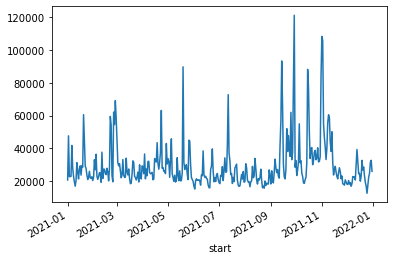

In [110]:
df3['tweet_count'].plot()

<AxesSubplot:xlabel='start'>

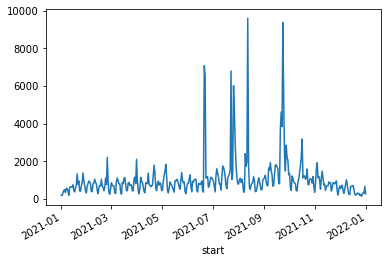

In [70]:
df3['tweet_count'].plot()

In [29]:
df = pd.DataFrame(response.data)

In [51]:
df2 = pd.DataFrame(response2.data)

In [52]:
df3 = pd.DataFrame(response3.data)

In [41]:
df['start'] = pd.to_datetime(df['start'])

In [42]:
df2['start'] = pd.to_datetime(df2['start'])

In [45]:
df = df.set_index('start')

In [46]:
df2 = df2.set_index('start')

<AxesSubplot:xlabel='start'>

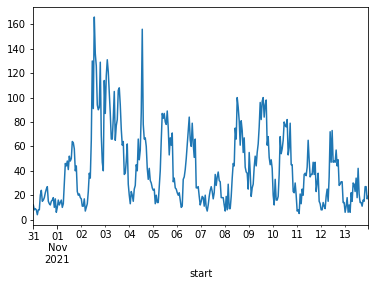

In [47]:
df['tweet_count'].plot()

<AxesSubplot:xlabel='start'>

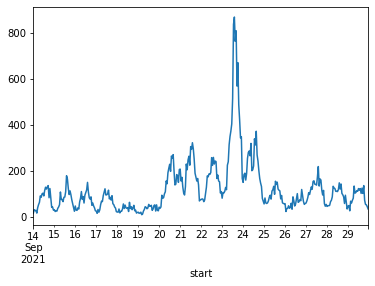

In [48]:
df2['tweet_count'].plot()

In [37]:
df2['tweet_count'].sum()

46066

In [31]:
df['tweet_count'].sum()

14050